In [1]:
import xarray as xr
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from rasterio.plot import show

In [2]:
# --- Step 0: Read and map the NetCDF data ---
file = '/scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/NF_SF_region_mask.nc'
orig_data = xr.open_dataset(file)

# Define the mapping: 'NF' -> 0.0, 'SF' -> 1.0, 'NA' -> np.nan
mapping = {'NF': 0.0, 'SF': 1.0, 'NA': np.nan}

# Apply mapping
region_numeric = xr.apply_ufunc(
    lambda x: np.vectorize(mapping.get)(x),
    orig_data['region'],
    dask='allowed',
    output_dtypes=[float]
)

data = xr.Dataset({'region': region_numeric})
variable = 'region'
datas = data[variable]
lat = data['lat'].values
lon = data['lon'].values
values = datas.values
values = np.flipud(values)  # flip vertically for rasterio

# --- Constants ---
nodata_value = -9999
values[np.isnan(values)] = nodata_value

res_y = np.abs(lat[1] - lat[0])
res_x = np.abs(lon[1] - lon[0])

# --- Step 1: Save to GeoTIFF in EPSG:2393 (KKJ) ---
output_file_kkj = '/scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/khk_mask_kkj.tif'
output_file_tm35fin = '/scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/khk_mask_tm35.tif'
output_file_resampled = '/scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/khk_mask_10x10.tif'
reference_grid_path = '/scratch/project_2000908/nousu/mNFI_to_NEP/METEO/AVGS/air_temperature.tif'

transform_kkj = from_origin(west=lon.min() - res_x / 2,
                            north=lat.max() + res_y / 2,
                            xsize=res_x,
                            ysize=res_y)

with rasterio.open(
    output_file_kkj, "w", driver="GTiff",
    height=values.shape[0],
    width=values.shape[1],
    count=1,
    dtype=values.dtype,
    crs="EPSG:2393",
    transform=transform_kkj,
    nodata=nodata_value
) as dst:
    dst.write(values, 1)

# --- Step 2: Reproject to EPSG:3067 ---
with rasterio.open(output_file_kkj) as src:
    transform_3067, width, height = calculate_default_transform(
        src.crs, "EPSG:3067", src.width, src.height, *src.bounds)

    kwargs = src.meta.copy()
    kwargs.update({
        "crs": "EPSG:3067",
        "transform": transform_3067,
        "width": width,
        "height": height
    })

    with rasterio.open(output_file_tm35fin, "w", **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform_3067,
            dst_crs="EPSG:3067",
            resampling=Resampling.nearest,
            src_nodata=nodata_value,
            dst_nodata=nodata_value
        )

print(f"Reprojected to EPSG:3067 → {output_file_tm35fin}")

# --- Step 3: Resample to match reference grid (e.g., METEO) ---
with rasterio.open(reference_grid_path) as ref:
    ref_profile = ref.profile
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_width = ref.width
    ref_height = ref.height

with rasterio.open(output_file_tm35fin) as src:
    src_data = src.read(1)
    dst_data = np.full((ref_height, ref_width), nodata_value, dtype=src_data.dtype)

    reproject(
        source=src_data,
        destination=dst_data,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=Resampling.nearest,
        src_nodata=nodata_value,
        dst_nodata=nodata_value
    )

    out_profile = ref_profile.copy()
    out_profile.update({
        "driver": "GTiff",
        "nodata": nodata_value
    })

    with rasterio.open(output_file_resampled, "w", **out_profile) as dst:
        dst.write(dst_data, 1)

print(f"Resampled to match reference grid → {output_file_resampled}")

Reprojected to EPSG:3067 → /scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/khk_mask_tm35.tif
Resampled to match reference grid → /scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/khk_mask_10x10.tif


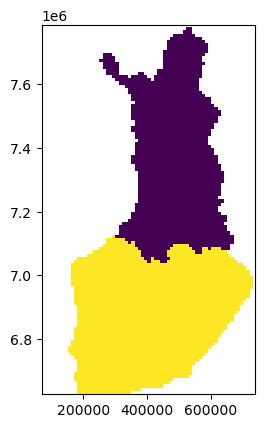

In [3]:
file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/MASKS/khk_mask_10x10.tif'
with rasterio.open(file) as src:
    data = src.read(1)
    show(src)